---
title: "Image matching example with DISK local features"
description: "In this tutorial we are going to show how to perform image matching using a DISK algorithm"
author:
    - "Dmytro Mishkin"
date: 04-01-2023
categories:
    - Intermediate
    - DISK
    - LAF
    - Image matching
    - kornia.feature
image: "../tutorials/assets/image_matching_disk.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/image_matching_disk.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

First, we will install everything needed:


*  fresh version of [kornia](https://github.com/kornia/kornia) for [DISK](https://arxiv.org/abs/2006.13566)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization

Docs: [`kornia.feature.DISK`](https://kornia.readthedocs.io/en/latest/feature.html#kornia.feature.DISK)


In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs
!pip install kornia_moons --no-deps
!pip install opencv-python --upgrade

Now let's download an image pair


In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"
download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

First, imports.

In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

device = K.utils.get_cuda_or_mps_device_if_available()
print(device)

mps


Here we show how to use LightGlue with provided kornia `LightGlueMatcher` interface

In [ ]:
# %%capture
fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

lg_matcher = KF.LightGlueMatcher('disk').eval().to(device)


img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

num_features = 2048
disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)



with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    lafs1 = KF.laf_from_center_scale_ori(kps1[None], torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], torch.ones(1, len(kps2), 1, 1, device=device))
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)


print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")

Loaded LightGlue model


And here the same with original `LightGlue` object

In [ ]:
lg = KF.LightGlue('disk').to(device).eval()

image0 = {"keypoints": features1.keypoints[None],
          "descriptors": features1.descriptors[None],
          "image_size": torch.tensor(img1.shape[-2:][::-1]).view(1,2).to(device)}
image1 = {"keypoints": features2.keypoints[None],
          "descriptors": features2.descriptors[None],
          "image_size": torch.tensor(img2.shape[-2:][::-1]).view(1,2).to(device)}

with torch.inference_mode():
    out = lg({"image0":image0, "image1": image1})
    idxs = out["matches"][0]
    print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")


724 tentative matches with DISK LightGlue


RANSAC to get fundamental matrix

In [ ]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")

Let's draw the inliers in green and tentative correspondences in yellow

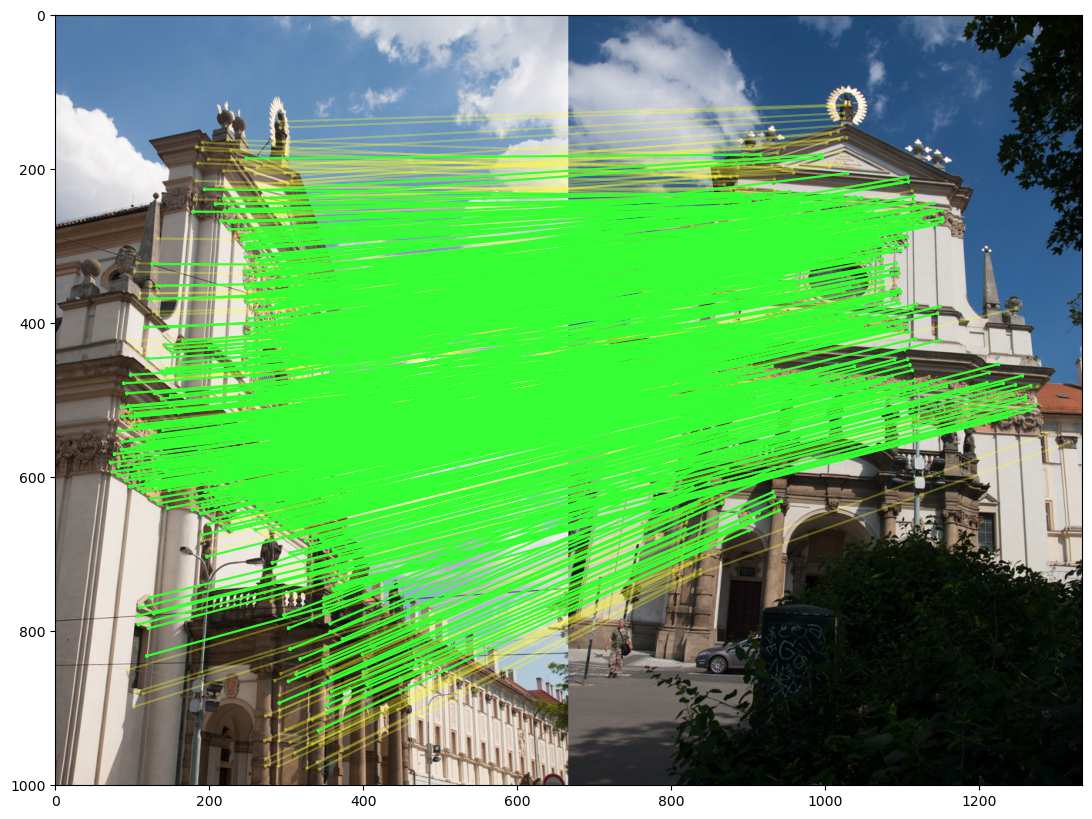

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)